<h2> Implementation of Flow-based Difference of Guassian (FDoG) </h2>

The formula to compute DoG is given below: 
Dσ,k,τ(x) = Gσ(x) − τ · Gkσ(x) <br>
For FDoG we compute the DoG but based on the Edge Tangential Flow (ETF) vector of the image so that the edges are not comprimised when computing the DoG<br>

<h4>PARAMETERS:</h4>
- <i>sigma_m</i>  -> length of gradient line flow kernel (determines the degree of line coherence to enforce)<br>
- <i>sigma_c</i> -> controls how many center pixels are considered<br>
- <i>sigma_s</i> -> how many surrounding pixels are considered (sigma_s = 1.6 * sigma_c)<br>
- <i>rho</i> -> Gc - p*Gs the p here is rho (calculation of DoG)<br>
- <i>tau</i> -> thresholding value<br>
<b>INPUT SHOULD BE GREYSCALE</b>

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def conv2D(img,kernel):
    h,w = img.shape[0:2]
    k = kernel.shape[0]
    padding = int(k/2)
    
    # padded = np.zeros((h + padding*2, w + padding*2)) #extra zeroes so that kernel fits properly
    # padded[padding:h+padding,padding:w+padding] = img[:,:,0] #setting everything except the padding to be equal to image
    
    padded = np.pad(img,int(k/2), 'constant', constant_values=(0))
    output = np.zeros((h,w))
    for i in range(padding, h+padding):
        for j in range(padding, w+padding):
            # print(padded[j-padding: j+padding+1, i-padding: i+padding+1])
            output[i - padding,j-padding] = (kernel * padded[i-padding: i+padding+1, j-padding: j+padding+1]).sum()
    
    output = (np.stack((output,output,output),axis=2)).astype(np.uint8) #stacking the channels together
    return output

def sobelFilter(img):
    #img = img[:,:,0]
    gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) 
    gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) 
    
    ex = conv2D(img,gx)
    ey = conv2D(img,gy)
    return [ex,ey]

In [20]:
import cv2
import numpy as np

#sigma taken here to compute etf is 2
def ETF(image):
    image = np.double(image)
    maxi = np.max(image)
    image = image / maxi 
    M = image.shape[0]
    N = image.shape[1]
    # Applying Gaussian blurring to reduce noise
    sd = 2
    blurred_image = cv2.GaussianBlur(image,(3,3),sd)

    Gx, Gy = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3), cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
    G = np.sqrt(Gx**2 + Gy**2)
    G_norm = G / np.max(G)

    G[G == 0] = 1 #making sure we don't divide by zero

    # Vectors perpendicular to the gradient (local tangential direction)
    tx = (-1 * Gy) / G
    ty = Gx / G
    x,y = tx.shape[0:2]
    size = 1
    G = np.pad(G_norm, [size,size], 'symmetric')
    tx = np.pad(tx, [size,size], 'symmetric')
    ty = np.pad(ty, [size,size], 'symmetric')

    output_image_x = np.zeros((x,y))
    output_image_y = np.zeros((x,y))
                                   
    for i in range(size+1,size + x - 1):
        for j in range(size+1,size + y - 1):
            # Extract local window
            win_x = range(i - size, i + size)
            win_y = range(j - size, j + size)
            
            wm = (G[win_x,win_y]- G[i,j] + 1)/2
            X_tx = tx[i,j]
            Y_tx = ty[i,j]
            
            X_ty = tx[win_x,win_y]
            Y_ty = ty[win_x,win_y]
                                   
            prod_x = X_tx*X_ty
            prod_y = Y_tx*Y_ty
            dot_prod = prod_x + prod_y
            wd = np.abs(dot_prod)
                                   
            phi = dot_prod
            phi[phi<=0]=-1
            phi[phi>0]=1
                                   
            Ix = np.multiply(wm,wd)
            Ix = np.multiply(Ix, phi)
            Ix = np.multiply(Ix, X_ty)                       
            Iy = np.multiply(wm,wd)
            Iy = np.multiply(Iy, phi)
            Iy = np.multiply(Iy, Y_ty)

            output_image_x[i - size, j - size] = np.sum(Ix)
            output_image_y[i - size, j - size] = np.sum(Iy)
            
    # Normalize the vectors
    norm = np.sqrt(output_image_x**2 + output_image_y**2)
    output_image_x = output_image_x/norm
    output_image_y = output_image_y/norm                               
    
                                   
    ETF_output = np.zeros((x,y,2))
    ETF_output[:,:,0] = output_image_x
    ETF_output[:,:,1] = output_image_y

    return ETF_output

def ETF_to_tangent(ETF_image, m, n):
    tangent_pg1 = np.zeros((m, n))
    condition = np.logical_and(-1 <= ETF_image[:, :, 0], ETF_image[:, :, 0] <= -np.sin(np.pi/8))
    tangent_pg1[condition] = -1
    # tangent_pg1[((-1 <= ETF_image[:, :, 0]) and (ETF_image[:, :, 0])) <= -np.sin(np.pi / 8)] = -1
    condition = np.logical_and(-np.sin(np.pi / 8) < ETF_image[:, :, 0], (ETF_image[:, :, 0]) <= np.sin(np.pi / 8))
    tangent_pg1[condition] = 0
    # tangent_pg1[(((-np.sin(np.pi / 8) < ETF_image[:, :, 0]) and (ETF_image[:, :, 0])) <= np.sin(np.pi / 8))] = 0
    condition = np.logical_and((-np.sin(np.pi / 8)) < ETF_image[:, :, 0], (ETF_image[:, :, 0]) <= 1)
    tangent_pg1[condition] = 1
    # tangent_pg1[((np.sin(np.pi / 8) < ETF_image[:, :, 0]) and (ETF_image[:, :, 0])) <= 1] = 1
    
    tangent_pg2 = np.zeros((m, n))
    condition = np.logical_and(-1 <= ETF_image[:, :, 1], ETF_image[:, :, 1] <= -np.sin(np.pi/8))
    tangent_pg2[condition] = -1
    # tangent_pg2[(-1 <= ETF_image[:, :, 1]) and (ETF_image[:, :, 1] <= -np.sin(np.pi / 8))] = -1
    condition = np.logical_and(-np.sin(np.pi / 8) < ETF_image[:, :, 1], (ETF_image[:, :, 1]) <= np.sin(np.pi / 8))
    tangent_pg2[condition] = 0
    # tangent_pg2[(-np.sin(np.pi / 8) < ETF_image[:, :, 1]) and (ETF_image[:, :, 1] <= np.sin(np.pi / 8))] = 0
    condition = np.logical_and((np.sin(np.pi / 8)) < ETF_image[:, :, 1], (ETF_image[:, :, 1]) <= 1)
    tangent_pg2[condition] = 1
    # tangent_pg2[(np.sin(np.pi / 8) < ETF_image[:, :, 1]) and (ETF_image[:, :, 1] <= 1)] = 1

    tangent = np.zeros_like(ETF_image)
    grad = np.zeros_like(ETF_image)
    tangent[:, :, 0] = tangent_pg2
    tangent[:, :, 1] = tangent_pg1
    grad[:, :, 0] = - tangent_pg1
    grad[:, :, 1] = tangent_pg2

    return [tangent, grad]



#PARAMETERS: 
#sigma_m  -> length of gradient line flow kernel (determines the degree of line coherence to enforce)
#sigma_c -> controls how many center pixels are considered
#sigma_s -> surrounding pixels (sigma_s = 1.6 * sigma_c)
#rho -> Gc - p*Gs the p here is rho (calculation of DoG)
#tau -> thresholding value
def FDOG(image, tangent, grad, sigma_c, rho, sigma_m, tau):
    image = np.double(image)
    m, n = image.shape
    print(m,n)
    # Calculate H_g at each pixel
    H_g = np.zeros((m, n))
    sigma_s = 1.6 * sigma_c
    total_wt = 0

    for i in range(m):
        for j in range(n):
            for k in range(-np.floor(4 * sigma_s).astype(int),(np.floor(4 * sigma_s).astype(int) + 1)):
                x = j + (k * grad[i, j, 0])
                y = i + (k* grad[i, j, 1])
                
                if x < 1:
                    continue
                elif x >= n:
                    print
                    continue
                elif y < 1:
                    continue
                elif y >= m:
                    continue
                    
                
                dist_sqrd = ((k * grad[i, j, 0]) ** 2) + ((k * grad[i, j, 1]) ** 2)
                wt = np.exp(-dist_sqrd / (2 * (sigma_c ** 2)))/sigma_c
                wt = wt - (rho * (np.exp(-dist_sqrd / (2 * (sigma_s ** 2)))/sigma_s))
                wt = wt / np.sqrt(2 * np.pi)
        
                H_g[i, j] = (H_g[i, j] + wt * image[int(y) - 1, int(x) - 1]).astype(int)
                total_wt += wt

            H_g[i, j] = H_g[i, j]/total_wt
            total_wt = 0
            
    H_e = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            x, y = j, i
            dist = 0
            wt = np.exp(-(dist ** 2) / (2 * sigma_m ** 2)) / (sigma_m * np.sqrt(2 * np.pi))
            H_e[i, j] += wt * H_g[y, x]
            total_wt = wt

            for k in range(1, np.floor(4 * sigma_m).astype(int) + 1):
                if (x >= n) or (y >= m):
                    continue
                    
                x_plus_tangent_0 = int(x + tangent[int(y), int(x), 0])
                y_plus_tangent_1 = int(y + tangent[int(y), int(x), 1])

                if x_plus_tangent_0 < 1:
                    continue
                elif x_plus_tangent_0 >= n:
                    continue
                elif y_plus_tangent_1 < 1:
                    continue
                elif y_plus_tangent_1 >= m:
                    continue
                    
                dist += np.sqrt(tangent[int(y), int(x), 0] ** 2 + tangent[int(y), int(x), 1] ** 2)
                wt = np.exp(-(dist ** 2) / (2 * sigma_m ** 2)) / (sigma_m * np.sqrt(2 * np.pi))
                H_e[i, j] += wt * H_g[y_plus_tangent_1 - 1, x_plus_tangent_0 - 1]
                total_wt += wt
                temp_x, temp_y = x, y
                x, y = temp_x + tangent[int(temp_y), int(temp_x), 0], temp_y + tangent[int(temp_y), int(temp_x), 1]

            x, y = j, i
            dist = 0
            for k in range(1, np.floor(4 * sigma_m).astype(int) + 1):
                if (x >= n) or (y >= m):
                    continue
                    
                x_plus_tangent_0 = int(x - tangent[int(y), int(x), 0])
                y_plus_tangent_1 = int(y - tangent[int(y), int(x), 1])

                if x_plus_tangent_0 < 1:
                    continue
                elif x_plus_tangent_0 > n:
                    continue
                elif y_plus_tangent_1 < 1:
                    continue
                elif y_plus_tangent_1 > m:
                    continue

                dist += np.sqrt(tangent[int(y), int(x), 0] ** 2 + tangent[int(y), int(x), 1] ** 2)
                wt = np.exp(-(dist ** 2) / (2 * sigma_m ** 2)) / (sigma_m * np.sqrt(2 * np.pi))
                H_e[i, j] += wt * H_g[int(y - tangent[int(y), int(x), 1] - 1), int(x - tangent[int(y), int(x), 0] - 1)]
                total_wt += wt
                temp_x, temp_y = x, y
                x, y = temp_x - tangent[int(temp_y), int(temp_x), 0], temp_y - tangent[int(temp_y), int(temp_x), 1]

            # Threshold
            if H_e[i, j] < 0 and (1 + np.tanh(H_e[i, j])) < tau:
                H_e[i, j] = 0
            else:
                H_e[i, j] = 1
    return H_e

/var/folders/zr/t9rc621d3jbds82pyx7m6n5w0000gn/T/ipykernel_50904/4042451669.py:67: RuntimeWarning: invalid value encountered in divide
  output_image_x = output_image_x/norm
/var/folders/zr/t9rc621d3jbds82pyx7m6n5w0000gn/T/ipykernel_50904/4042451669.py:68: RuntimeWarning: invalid value encountered in divide
  output_image_y = output_image_y/norm
/var/folders/zr/t9rc621d3jbds82pyx7m6n5w0000gn/T/ipykernel_50904/4042451669.py:151: RuntimeWarning: invalid value encountered in scalar divide
  H_g[i, j] = H_g[i, j]/total_wt


512 512


Text(0.5, 1.0, 'FDoG output')

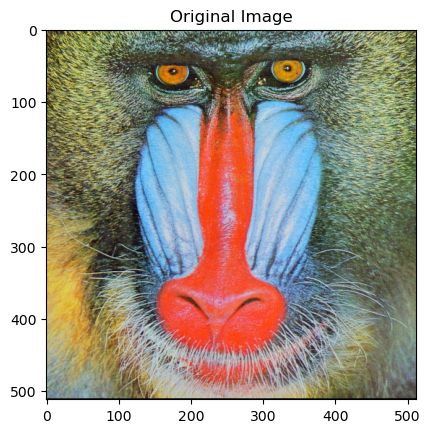

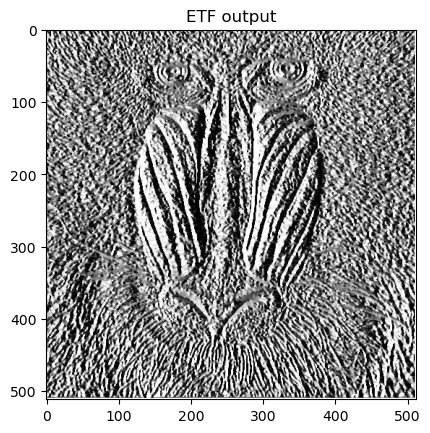

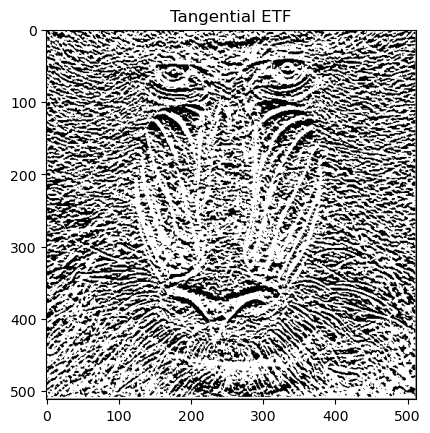

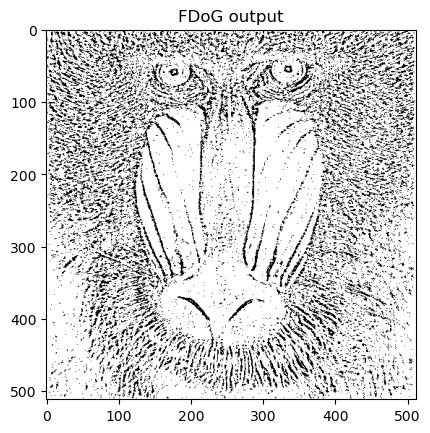

In [23]:
img = cv2.imread("baboonColor.png")
plt.figure()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Original Image")
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

output = ETF(img)
plt.figure()
plt.imshow(output[:,:,1],cmap="gray")
plt.title("ETF output")

m = img.shape[0]
n = img.shape[1]
[tan,grad] = ETF_to_tangent(output,m,n)
plt.figure()
plt.imshow(tan[:,:,1],cmap="gray")
plt.title("Tangential ETF")

result = FDOG(img, tan, grad, 1.5, 0.99, 0.15, 0.5)
plt.figure()
plt.imshow(result,cmap="gray")
plt.title("FDoG output")

In [1]:
# img = cv2.imread("lala_land.jpg")
# plt.figure()
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.title("Original Image")
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Dx = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
# Dy = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)

# #[Dx, Dy] = sobelFilter(img)
# print(Dx.shape)
# ST = np.stack((Dx*Dx,Dx*Dy,Dy*Dy),axis = 2)

# ST = (ST - ST.min()) / (ST.max() - ST.min())
# # Multiply by 255 to scale back to [0, 255] range for integer display
# ST = (ST * 255).astype(np.uint8)

# sigma_c =2.4

# SST = cv2.GaussianBlur(ST, (0, 0), sigma_c)
# plt.figure(figsize=(10,10))
# plt.imshow(ST*9)
# plt.title("ST")

# plt.figure(figsize=(10,10))
# plt.imshow(SST*9)
# plt.title("SST")
